In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import neurosat_policy
neurosat_policy.VARIABLE_NUM = 10

In [3]:
from graph_policy import clauses_to_matrix
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf import get_random_kcnf, CNF, get_sats_SR, get_pos_SR
from tqdm import tqdm

In [4]:
np.set_printoptions(precision=2, suppress=True)

In [5]:
import tensorflow as tf
import os

BATCH_SIZE = 64

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
# META_FILE = "models/activepolicy-18-03-28-122105/model-10000064.meta" # ok results, no error > 80% usually, usually better than mostcommon
# META_FILE = "series/18-03-24-020248/var8/models/activepolicy-18-03-24-020450/model-6400000.meta"  # usually slightly worse than mostcommon
META_FILE = "models/neuropol-18-09-18-002956/model-7268352.meta"


sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(META_FILE)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from models/neuropol-18-09-18-002956/model-7268352


In [6]:
g_inputs = graph.get_tensor_by_name("inputs:0")

In [7]:
#g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
#g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [8]:
LEVEL = 20

In [9]:
g_policy_probs = graph.get_tensor_by_name('policy_prob_{}:0'.format(LEVEL))
g_sat_probs = graph.get_tensor_by_name('sat_prob_{}:0'.format(LEVEL))

In [10]:
np.set_printoptions(precision=3, suppress=True)

In [11]:
'''
inputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)
lengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)

sat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})

print(sat_prob[0], policy_probs[0])
'''

'\ninputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)\nlengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)\n\nsat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})\n\nprint(sat_prob[0], policy_probs[0])\n'

In [12]:
# Because we have to pass full batch

logfile = open("/tmp/log_2", "w")
#import sys
#logfile = sys.stdout

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar

In [13]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    for sat in tqdm(sats):
        dpll = dpll_cls()
        res = dpll.run(sat)
        assert res is not None
        steps.append(dpll.number_of_runs)
        errors.append(dpll.number_of_errors)
    return steps, errors

In [24]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [21]:
def print_all(s, n, m):
    # def get_sats_SR(sample_number, min_variable_number, clause_number, max_variable_number=None):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        if DPLL().run(sat) is not None:
            sats.append(sat)
    assert len(sats) == S
    # sats = get_sats_SR(S,M,N)
    # for sat in sats:
    #    print(sat)
    # assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    # compute_and_print_steps(sats, DPLL)
    compute_and_print_steps(sats, RandomVarDPLL)
    compute_and_print_steps(sats, RandomClauseDPLL)
    compute_and_print_steps(sats, GraphBasedDPLL)
    compute_and_print_steps(sats, MostCommonVarDPLL)
    logfile.flush(), 

 30%|███       | 3/10 [00:00<00:00, 25.07it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:00<00:00, 23.89it/s]


#Sats: 10; avg step: 955.00; stdev step: 692.49; avg error: 7.00; stdev error: 2.45


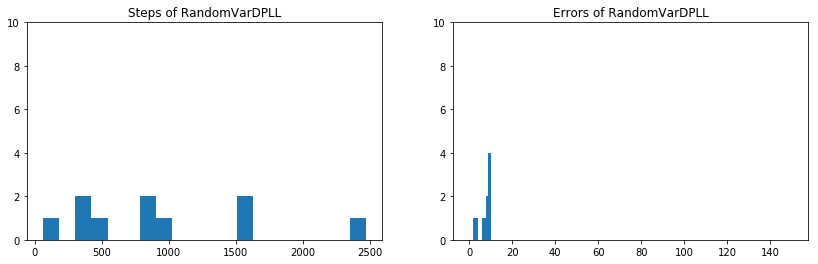

100%|██████████| 10/10 [00:00<00:00, 38.98it/s]


#Sats: 10; avg step: 581.80; stdev step: 382.14; avg error: 5.10; stdev error: 1.70


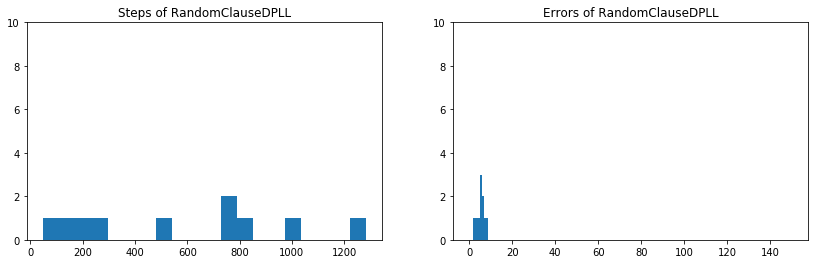

100%|██████████| 10/10 [06:22<00:00, 14.55s/it]


#Sats: 10; avg step: 304.20; stdev step: 865.27; avg error: 0.20; stdev error: 0.60


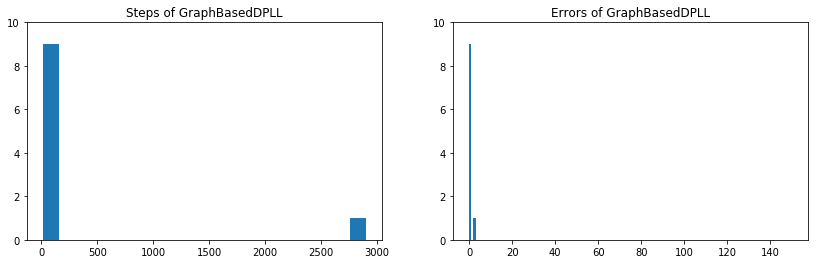

100%|██████████| 10/10 [00:00<00:00, 65.02it/s]


#Sats: 10; avg step: 294.50; stdev step: 188.51; avg error: 2.60; stdev error: 0.66


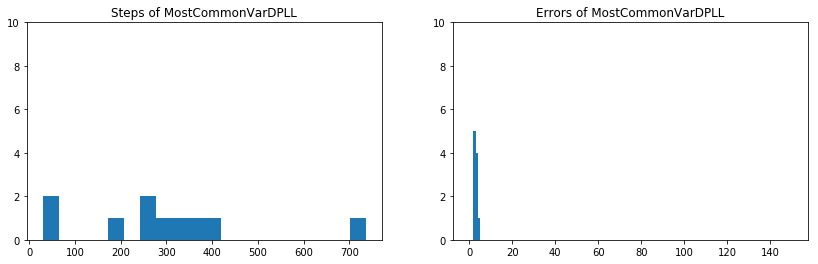

In [23]:
print_all(10, 200, 15)

100%|██████████| 10/10 [00:00<00:00, 535.09it/s]

We have generated 10 formulas
#Sats: 10; avg step: 60.50; stdev step: 27.66; avg error: 4.10; stdev error: 1.22


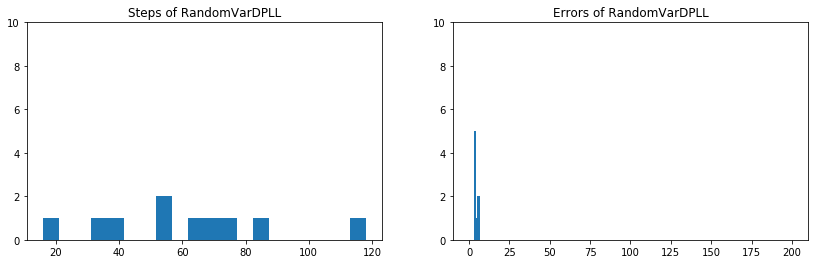

100%|██████████| 10/10 [00:00<00:00, 438.18it/s]


#Sats: 10; avg step: 74.00; stdev step: 17.88; avg error: 3.30; stdev error: 0.64


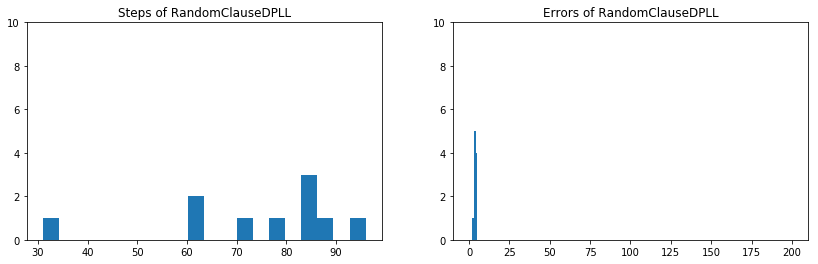

100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


#Sats: 10; avg step: 9.00; stdev step: 0.00; avg error: 0.00; stdev error: 0.00


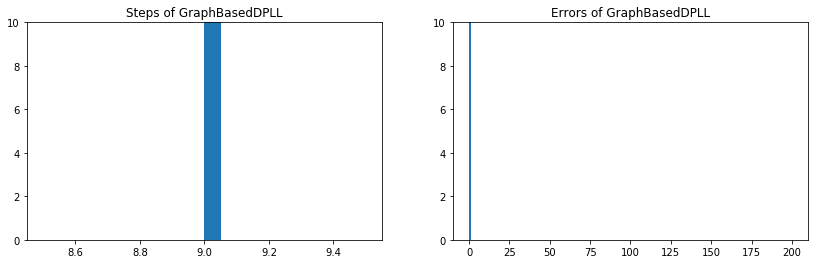

100%|██████████| 10/10 [00:00<00:00, 916.97it/s]


#Sats: 10; avg step: 24.70; stdev step: 21.09; avg error: 0.80; stdev error: 0.75


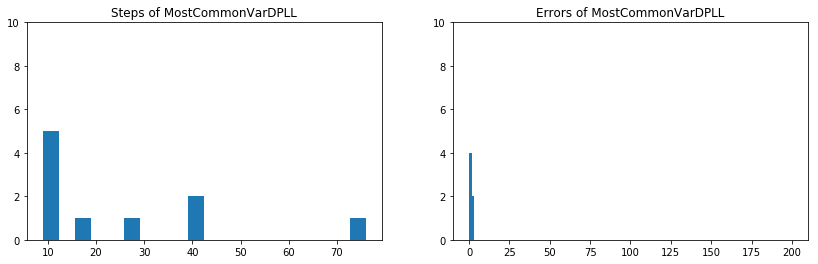

In [25]:
print_all(10, 200, 8)

100%|██████████| 10/10 [00:00<00:00, 195.54it/s]

We have generated 10 formulas
#Sats: 10; avg step: 170.30; stdev step: 93.37; avg error: 6.20; stdev error: 1.54


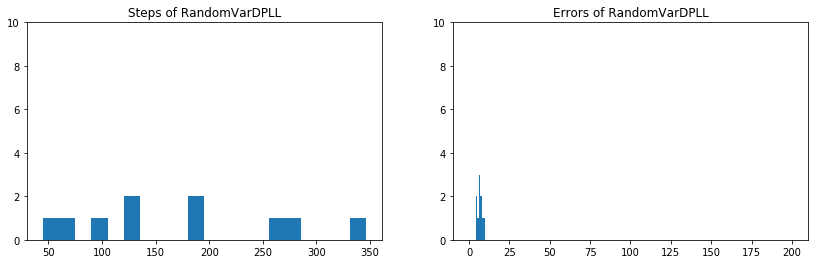

100%|██████████| 10/10 [00:00<00:00, 225.23it/s]


#Sats: 10; avg step: 94.90; stdev step: 48.37; avg error: 3.70; stdev error: 1.10


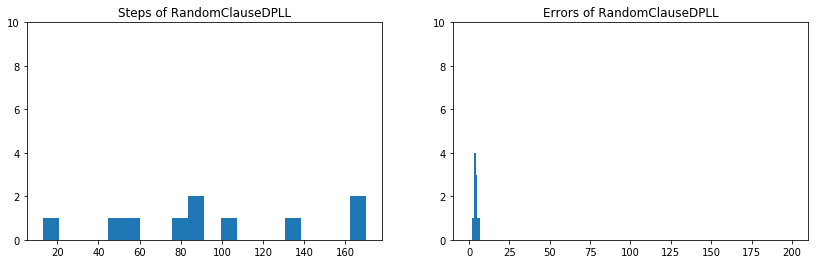

100%|██████████| 10/10 [00:26<00:00,  2.66s/it]


#Sats: 10; avg step: 11.90; stdev step: 2.70; avg error: 0.10; stdev error: 0.30


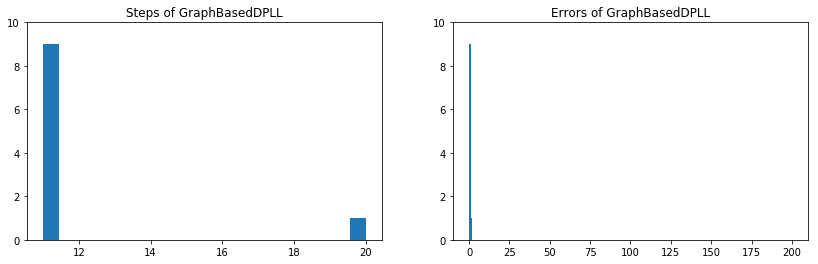

100%|██████████| 10/10 [00:00<00:00, 491.31it/s]


#Sats: 10; avg step: 24.40; stdev step: 12.49; avg error: 1.30; stdev error: 0.90


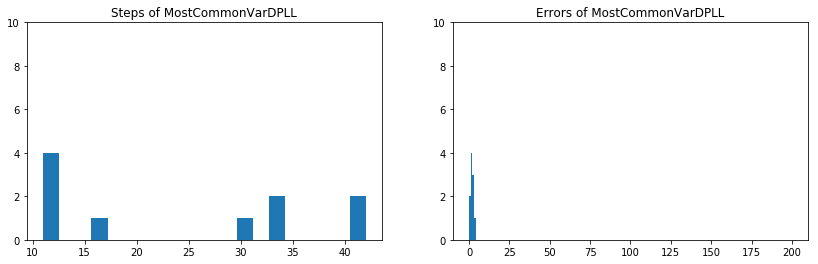

In [26]:
print_all(10, 200, 10)

100%|██████████| 10/10 [00:00<00:00, 120.11it/s]

We have generated 10 formulas
#Sats: 10; avg step: 260.60; stdev step: 200.45; avg error: 5.60; stdev error: 1.74


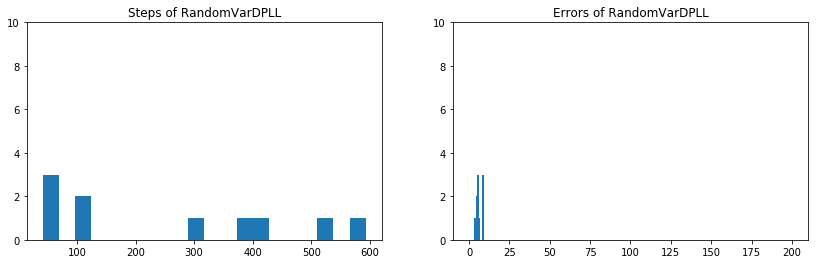

100%|██████████| 10/10 [00:00<00:00, 109.23it/s]


#Sats: 10; avg step: 227.50; stdev step: 138.15; avg error: 3.80; stdev error: 1.33


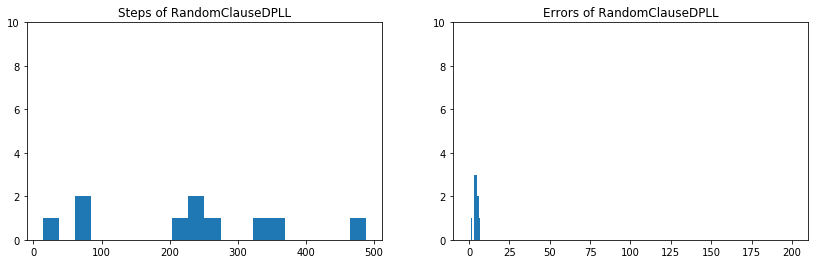

100%|██████████| 10/10 [00:56<00:00, 10.86s/it]


#Sats: 10; avg step: 40.10; stdev step: 81.30; avg error: 0.10; stdev error: 0.30


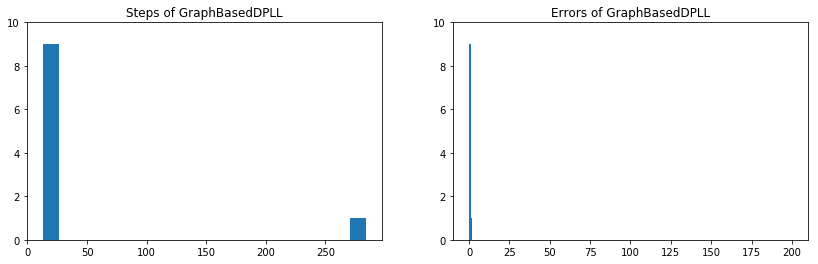

100%|██████████| 10/10 [00:00<00:00, 280.82it/s]


#Sats: 10; avg step: 69.20; stdev step: 65.82; avg error: 1.70; stdev error: 0.64


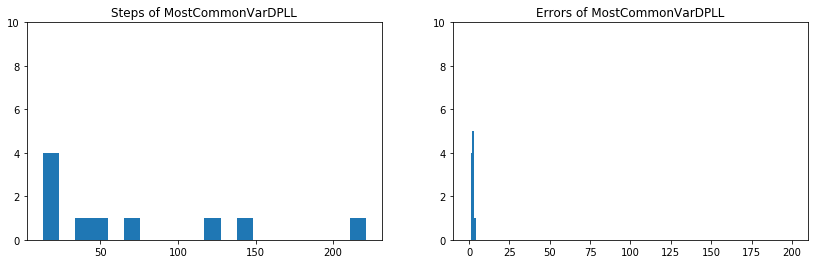

In [27]:
print_all(10, 200, 12)

 60%|██████    | 6/10 [00:00<00:00, 51.99it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:00<00:00, 45.97it/s]


#Sats: 10; avg step: 661.50; stdev step: 442.39; avg error: 7.10; stdev error: 1.87


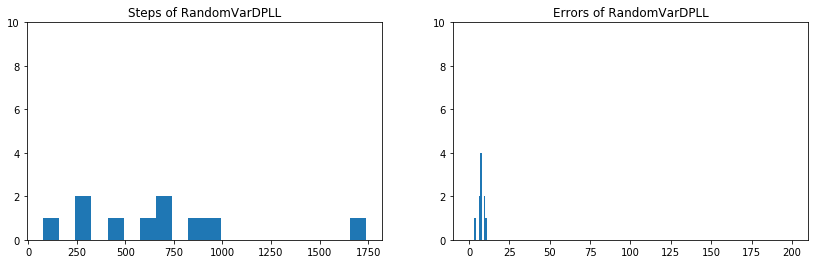

100%|██████████| 10/10 [00:00<00:00, 52.84it/s]


#Sats: 10; avg step: 480.70; stdev step: 251.02; avg error: 5.10; stdev error: 1.22


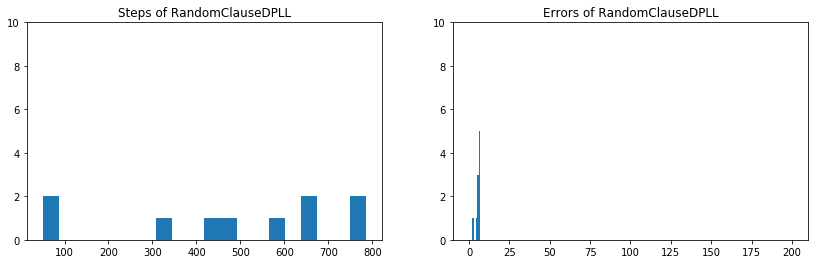

100%|██████████| 10/10 [02:58<00:00, 15.20s/it]


#Sats: 10; avg step: 139.30; stdev step: 314.71; avg error: 0.30; stdev error: 0.64


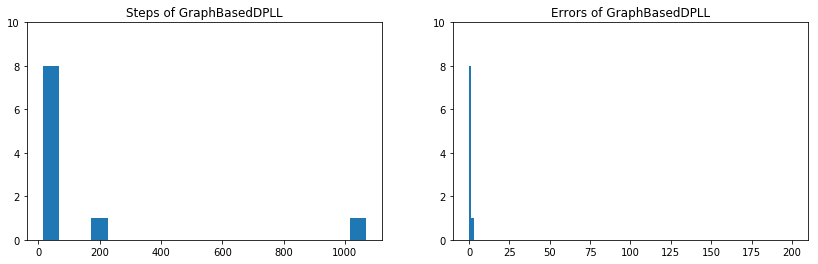

100%|██████████| 10/10 [00:00<00:00, 80.96it/s]


#Sats: 10; avg step: 250.50; stdev step: 223.58; avg error: 2.50; stdev error: 0.92


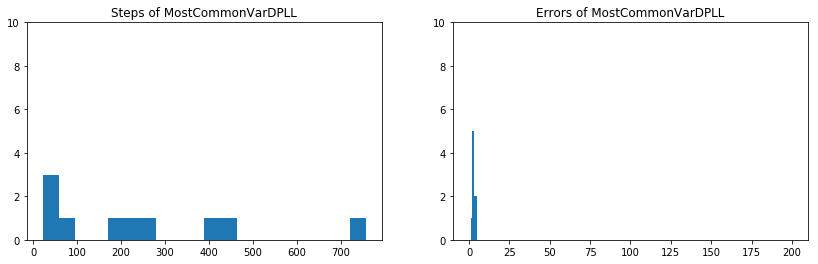

In [28]:
print_all(10, 200, 14)

 90%|█████████ | 9/10 [00:00<00:00, 37.06it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:00<00:00, 31.45it/s]


#Sats: 10; avg step: 692.70; stdev step: 428.25; avg error: 7.80; stdev error: 1.94


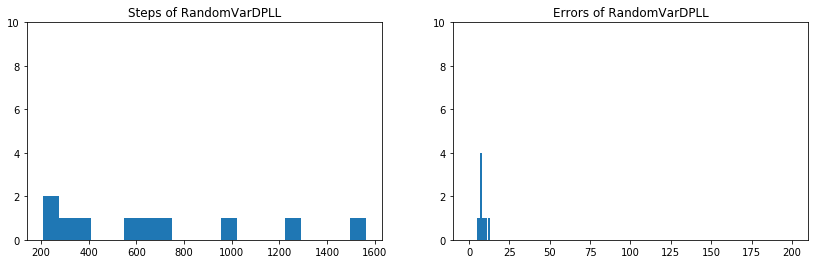

100%|██████████| 10/10 [00:00<00:00, 25.82it/s]


#Sats: 10; avg step: 666.20; stdev step: 406.35; avg error: 5.20; stdev error: 1.89


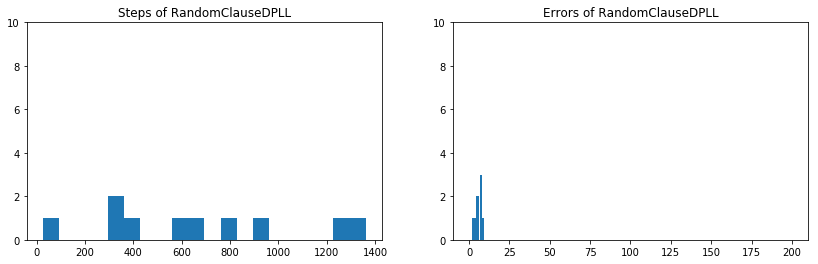

100%|██████████| 10/10 [02:41<00:00, 10.19s/it]


#Sats: 10; avg step: 83.70; stdev step: 200.10; avg error: 0.10; stdev error: 0.30


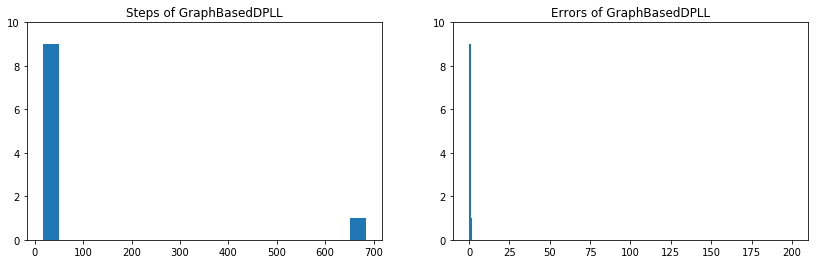

100%|██████████| 10/10 [00:00<00:00, 64.28it/s]


#Sats: 10; avg step: 199.40; stdev step: 215.62; avg error: 1.60; stdev error: 1.28


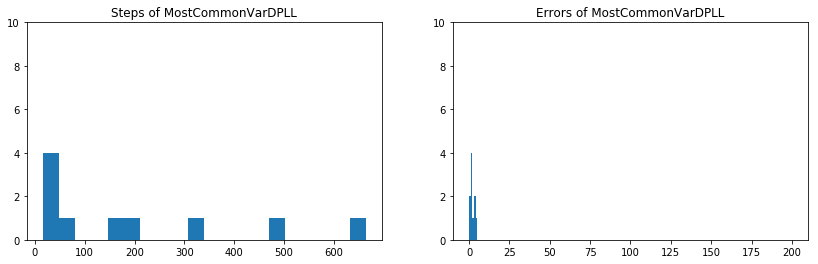

In [29]:
print_all(10, 200, 16)

 20%|██        | 2/10 [00:00<00:00,  9.66it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:01<00:00,  9.26it/s]


#Sats: 10; avg step: 2378.90; stdev step: 1268.69; avg error: 8.90; stdev error: 1.76


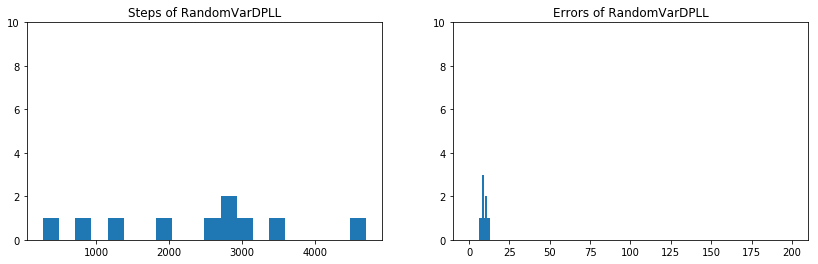

100%|██████████| 10/10 [00:00<00:00, 15.50it/s]


#Sats: 10; avg step: 1435.80; stdev step: 1055.60; avg error: 5.80; stdev error: 1.33


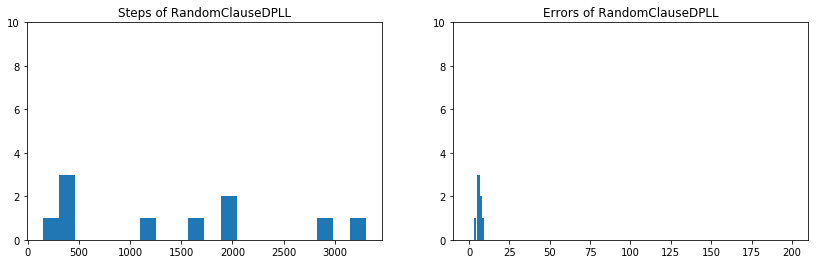

100%|██████████| 10/10 [13:42<00:00, 70.12s/it]


#Sats: 10; avg step: 497.00; stdev step: 822.03; avg error: 0.40; stdev error: 0.49


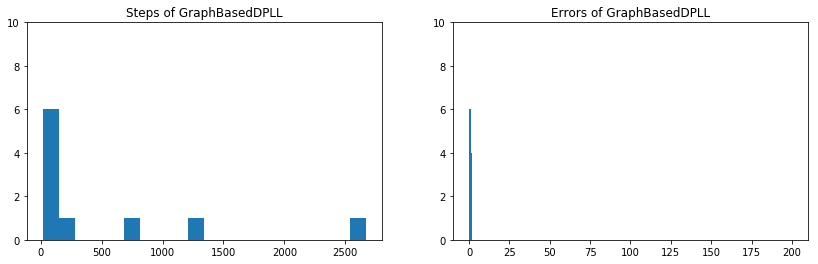

100%|██████████| 10/10 [00:00<00:00, 23.45it/s]


#Sats: 10; avg step: 744.50; stdev step: 537.48; avg error: 2.60; stdev error: 1.02


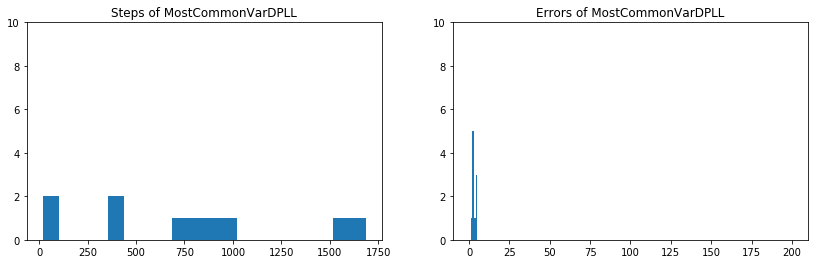

In [30]:
print_all(10, 200, 18)

 20%|██        | 2/10 [00:00<00:01,  7.51it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:01<00:00,  5.25it/s]


#Sats: 10; avg step: 4338.00; stdev step: 2921.12; avg error: 8.80; stdev error: 1.66


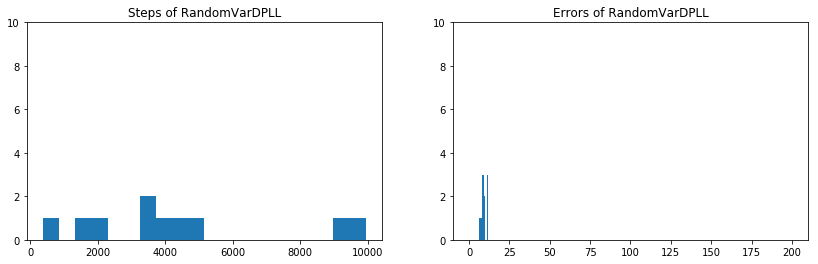

100%|██████████| 10/10 [00:01<00:00,  4.20it/s]


#Sats: 10; avg step: 3517.20; stdev step: 2314.10; avg error: 6.30; stdev error: 2.61


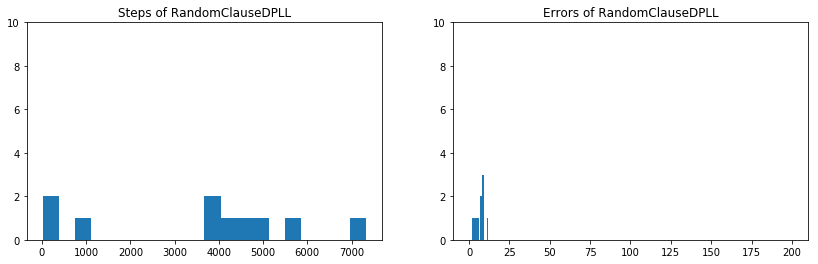

100%|██████████| 10/10 [35:06<00:00, 279.92s/it]


#Sats: 10; avg step: 1421.30; stdev step: 3016.47; avg error: 0.60; stdev error: 0.49


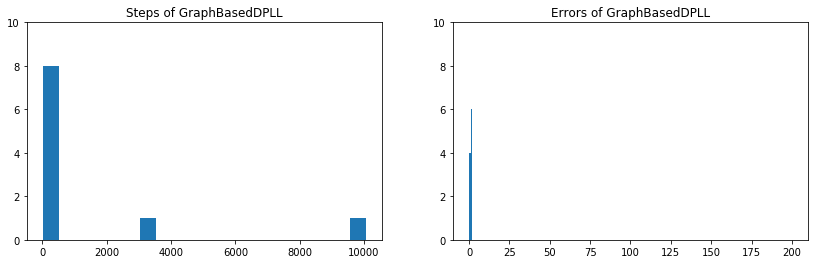

100%|██████████| 10/10 [00:00<00:00, 15.00it/s]


#Sats: 10; avg step: 1107.30; stdev step: 555.98; avg error: 3.30; stdev error: 1.42


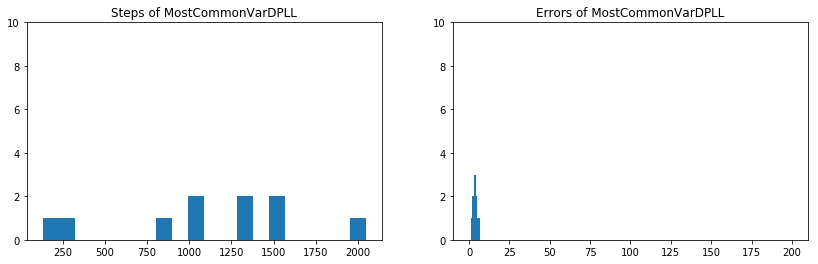

In [31]:
print_all(10, 200, 20)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


#Sats: 10; avg step: 17628.30; stdev step: 14494.01; avg error: 11.70; stdev error: 1.95


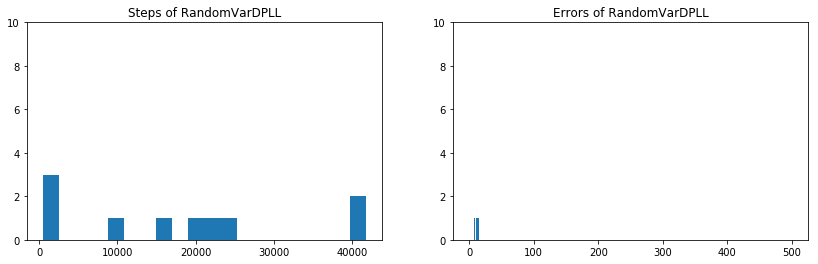

100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


#Sats: 10; avg step: 9054.70; stdev step: 5427.27; avg error: 7.50; stdev error: 2.29


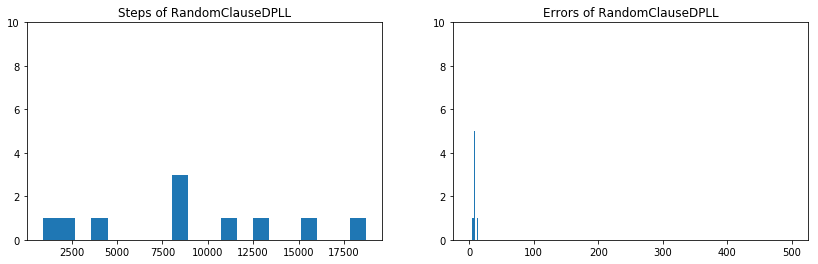

 10%|█         | 1/10 [00:16<02:30, 16.67s/it]

In [ ]:
print_all(10, 500, 25)